# Cluster Articles

Goal: In this notebook we will cluster the articles using our method, while trying to understand the clusters features.


prerequisites

In [2]:
!pip install sentence_transformers

     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 2.1MB 15.8MB/s 
     |████████████████████████████████| 1.2MB 39.1MB/s 
     |████████████████████████████████| 901kB 36.9MB/s 
     |████████████████████████████████| 3.3MB 45.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=393a12c129903e25cf60df5ae82cb9dce8bf5a25763441f733ea99ef3e27a820
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


Imports

In [3]:
import os

import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from google.colab import drive

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud, STOPWORDS


In [4]:
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

Dataset

In [5]:
drive.mount(r'/content/drive/',force_remount=True) 
data_dir = os.getcwd() + '/drive/My Drive/Colab Notebooks/AdvancedML/HW3/'
data_dir

Mounted at /content/drive/


'/content/drive/My Drive/Colab Notebooks/AdvancedML/HW3/'

In [6]:
df = pd.read_excel(data_dir + 'full_articles_10k.xlsx')
df.head()

,title,cord_uid,abstract,body_text
0,Chapter 6 Best practices and approaches using ...,rsgdqk1x,This chapter provides ten practical case studi...,"Throughout the previous chapters, this book ad..."
1,A Comparison: Prediction of Death and Infected...,k58agggx,"COVID-19 is a virus causing pneumonia, also kn...","COVID-19 is a virus causing pneumonia, also kn..."
2,Environmental implication of personal protecti...,ercubdf9,"In the present global health emergency, face m...",Due to the fast development in the domain of c...
3,The first three weeks of lockdown in England: ...,3u446iuy,With the outbreak of COVID-19 being declared a...,The first UK confirmed death from COVID-19 was...
4,Appendix B Climate change and global warming: ...,ora47nlw,Unknown,Climate change and global warming:\nImpacts on...


Method

In [7]:
titles = df.title.tolist()
abstracts = df.abstract.tolist()

df['title_embeddings']    = bert_model.encode(titles).tolist()
df['abstract_embeddings'] = bert_model.encode(abstracts).tolist()

Normalize

In [8]:
def normvecs(X):
  return X / (np.linalg.norm(X, 2, axis=1).reshape(X.shape[0], 1) +np.finfo(float).eps)

titles_emb = np.vstack(df.title_embeddings)
abstracts_emb = np.vstack(df.abstract_embeddings)

df['title_embeddings_norm']    = normvecs(titles_emb).tolist()
df['abstract_embeddings_norm'] = normvecs(abstracts_emb).tolist()

Dimension Reduction

In [9]:
titles_emb_norm = df.title_embeddings_norm.tolist()
abstracts_emb_norm = df.abstract_embeddings_norm.tolist()


In [10]:
pca = PCA(n_components=3)

# original
pca_title_embeddings = pca.fit_transform(titles_emb)
pca_abstract_embeddings = pca.fit_transform(abstracts_emb)

# norm
pca_title_embeddings_norm = pca.fit_transform(titles_emb_norm)
pca_abstract_embeddings_norm = pca.fit_transform(abstracts_emb_norm)



plot

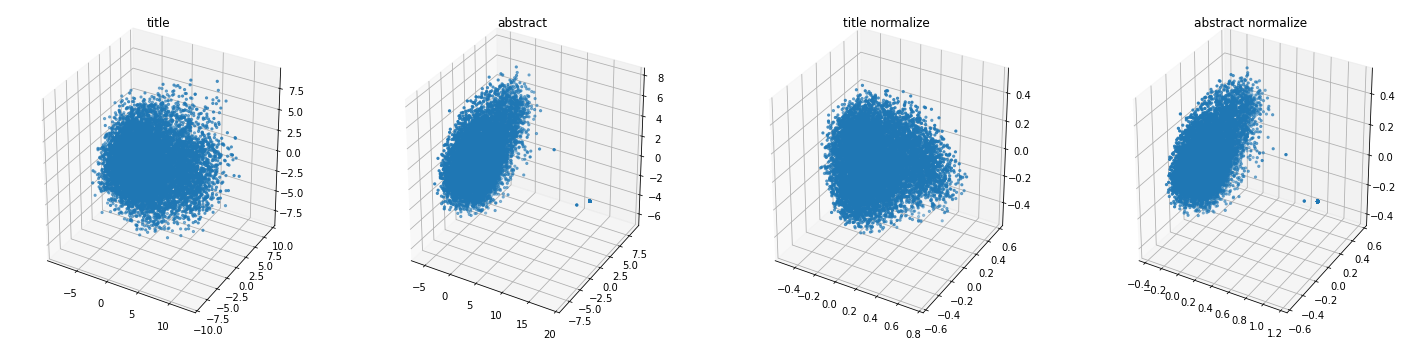

In [11]:
titles = ['title','abstract','title normalize','abstract normalize']
vecs = [pca_title_embeddings,pca_abstract_embeddings,pca_title_embeddings_norm,pca_abstract_embeddings_norm]

fig = plt.figure(1, figsize=(25, 6))

for i,(t,pca) in enumerate(zip(titles,vecs)):
  ax = fig.add_subplot(1, 4, i+1, projection='3d')
  ax.scatter(pca[:,0], pca[:,1], pca[:,2],marker='.')
  ax.set_title(t)
  fig.show()

Clustering

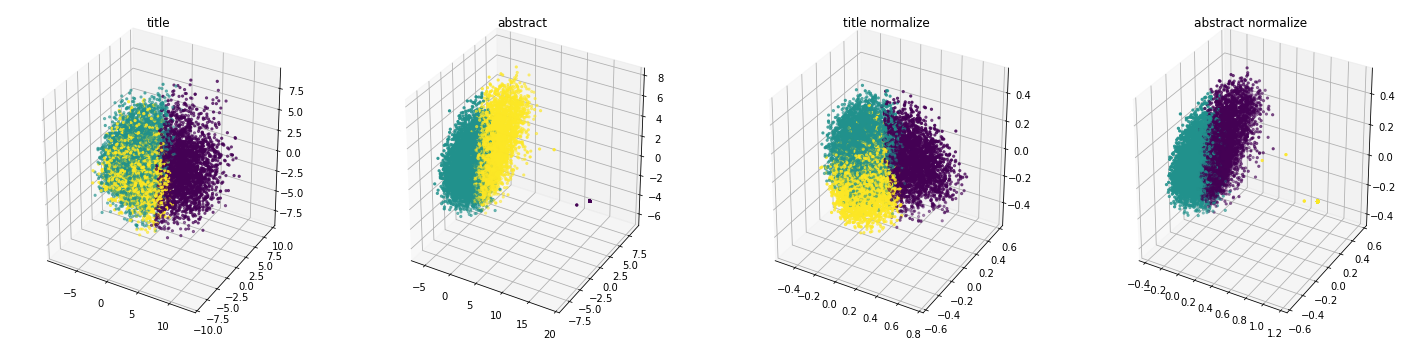

In [12]:
K = 10

kmeans = KMeans(n_clusters=3, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)

fig = plt.figure(1, figsize=(25, 6))
for i,(t,pca) in enumerate(zip(titles,vecs)):
  kmeans.fit(pca)
  labels = kmeans.labels_

  ax = fig.add_subplot(1, 4, i+1, projection='3d')
  ax.scatter(pca[:,0], pca[:,1], pca[:,2],marker='.',c=labels)
  ax.set_title(t)
fig.show()

Find the Right K and the right representation

In [13]:
K = 20
titles = ['title','abstract','title normalize','abstract normalize']
vecs = [pca_title_embeddings,pca_abstract_embeddings,pca_title_embeddings_norm,pca_abstract_embeddings_norm]

scores = pd.DataFrame(columns=['title','k','inertia','silhouette','labels'])

for k in range(2,K):
  kmeans = KMeans(n_clusters=k,max_iter=300,tol=1e-04,init='random',random_state=0)
  for i in range(len(titles)):
    kmeans.fit(vecs[i])
    
    title = titles[i]
    labels = kmeans.labels_  
    inertia = kmeans.inertia_
    silhouette = silhouette_score(vecs[i], labels)

    scores.loc[len(scores)] = [title,k,inertia,silhouette,labels]

Abstract

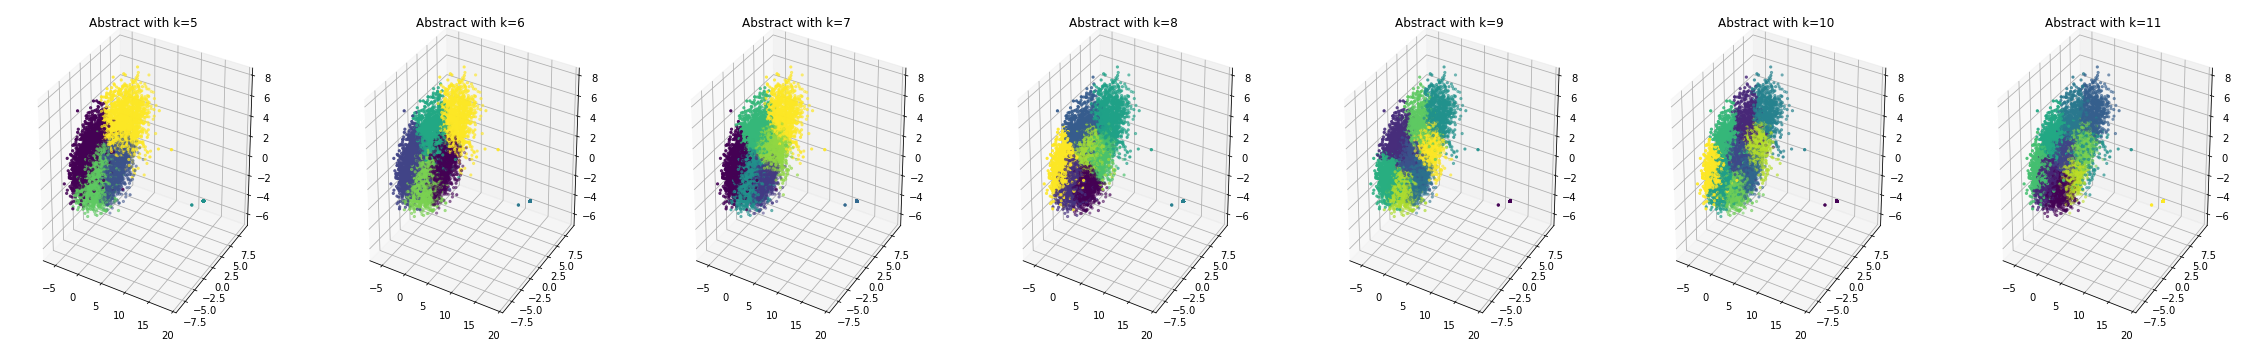

In [14]:
fig = plt.figure(1, figsize=(40, 6))

X = pca_abstract_embeddings
Ks = scores[scores.title=='abstract'].k.tolist()[3:10]
labels = scores[scores.title=='abstract'].labels.tolist()[3:10]

for i,(k,l) in enumerate(zip(Ks,labels)):
  ax = fig.add_subplot(1, 7, i+1, projection='3d')
  ax.scatter(X[:,0], X[:,1], X[:,2],marker='.',c=l)
  ax.set_title('Abstract with k=' + str(k))
fig.show()

''

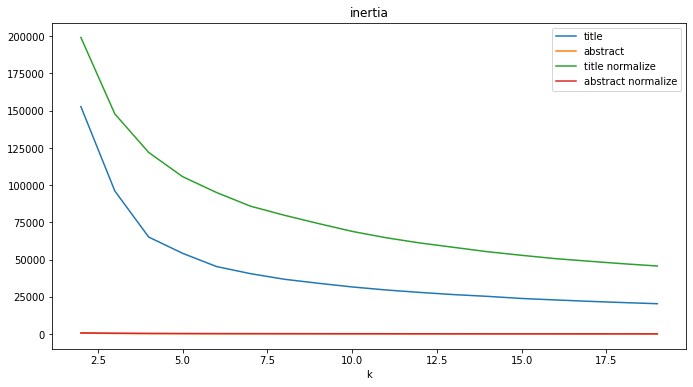

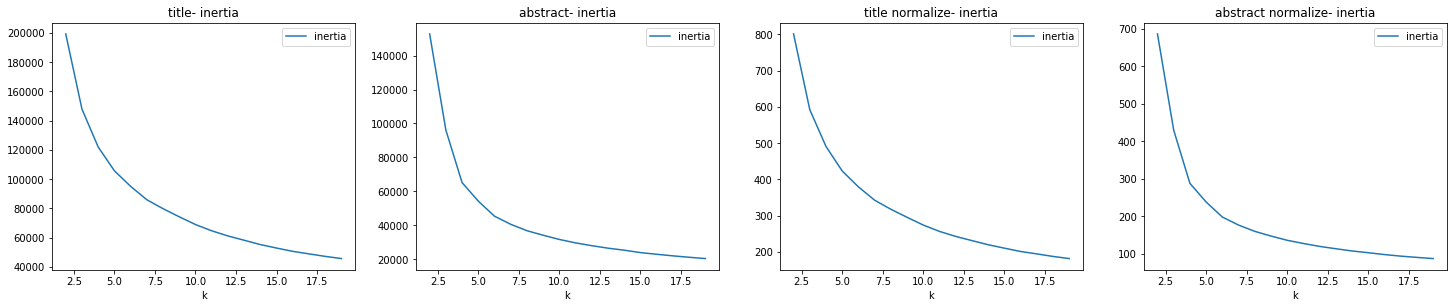

In [15]:
plt.figure(figsize=(25, 6)) 

ty = ['inertia']#,'silhouette']

for i,t in enumerate(ty):
  plt.subplot(1,2,i+1)
  scores.groupby(by='title').plot(x='k',y=t,ax=plt.gca())
  plt.legend(scores.title.tolist())
  plt.title(t)

plt.figure(figsize=(25, 10)) 

for i,t in enumerate(titles):
  # for i,t in enumerate(['inertia','silhouette']):
    plt.subplot(2,4,i+1)
    scores[scores.title==t].plot(x='k',y='inertia',ax=plt.gca())
    plt.title(t + '- inertia')

    # plt.subplot(2,4,4+i+1)
    # scores[scores.title==t].plot(x='k',y='silhouette',ax=plt.gca())
    # plt.title(t + ' - silhouette')

;

Due to the Elbow method - We can see that the best Ks are in the range of [7-12] for all representations.
And in that range, we choose k=7.

Explain the clusters
We will sample titles form the K clusters to understand and characterize the essence of each group.

In [49]:
k = 7
labels = scores[(scores.title=='title') & (scores.k==k)].labels.values[0]

Text(0.5, 1.0, 'Element count per group')

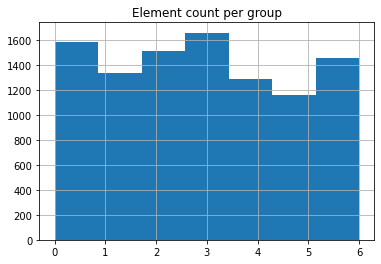

In [50]:
df['label'] = scores[(scores.title=='title') & (scores.k==k)].labels.values[0]
groups = df[['title','label']]

groups.label.hist(bins=k);
plt.title('Element count per group')

Groups Popular words:

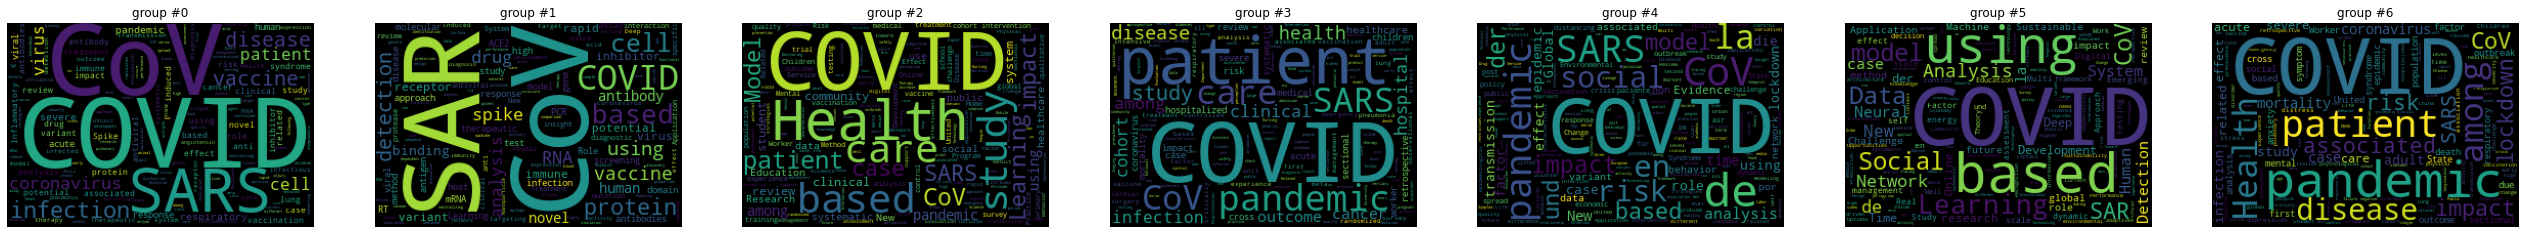

In [52]:
def plot_cloud(list_text,plottitle='',sub_i=0):
    text = "".join(list_text)  
    wordcloud = WordCloud(width = 300, height = 200, collocations=False, stopwords = STOPWORDS).generate(text)
    
    plt.subplot(1,7,sub_i+1)
    plt.imshow(wordcloud) 
    plt.axis("off");
    plt.title(plottitle)


plt.figure(figsize=(45, 10)) 
for g in np.unique(groups.label):
  plot_cloud(groups.title[groups.label==g].tolist(),plottitle='group #'+str(g),sub_i=g)

It seems group #1 have more focus on media(Online,Digital,Social),   
But the other seems to be variations of health(Risks,Clinical,Infection).
However not much of a difference.... Let's try TF-IDF!

the popular word are not surprising, but due to the huge amount of use.. lets try a different aproach: 

In [53]:
def get_tfidf_top_features(group_i,n_top=15,by='title',no_features=100):

  # get relevant group text
  documents = groups[groups.label==group_i][by].to_list()

  # vectorize
  tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
  
  # learn & predict
  tfidf = tfidf_vectorizer.fit_transform(documents)

  # sort by importance
  importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]

  # get words
  tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())

  return tfidf_feature_names[importance[:n_top]]

In [54]:
def remove_element(some_list,things):
  for thing in things:
    if thing in some_list: 
      some_list.remove(thing)


def get_groups_pop_words(groups,n_top=15,by='title'):
  gs = {}
  
  for g in np.unique(groups.label):
    # sort by abc just to make things more clear
    gs[g] = sorted(get_tfidf_top_features(group_i=g,n_top=n_top,by=by).tolist())

    # just to make the difference more clear
    remove_element(gs[g],['covid','19','sars','cov','pandemic','analysis','based','abstract','2020','research', 'results']) 
  
  return gs

In [55]:
gs = get_groups_pop_words(groups,by='title')
for g in gs:
  print('group #' + str(g) +' : ',end='\t')
  print(gs[g],end='\n\n')

group #0 : 	['coronavirus', 'disease', 'human', 'infection', 'patients', 'severe', 'study', 'vaccine', 'viral', 'virus']

group #1 : 	['antibody', 'cell', 'detection', 'human', 'novel', 'protein', 'rna', 'spike', 'using']

group #2 : 	['care', 'clinical', 'health', 'impact', 'learning', 'review', 'study', 'using']

group #3 : 	['cancer', 'care', 'clinical', 'disease', 'health', 'hospital', 'impact', 'patient', 'patients', 'study']

group #4 : 	['der', 'en', 'impact', 'la', 'model', 'new', 'risk', 'social']

group #5 : 	['approach', 'data', 'human', 'learning', 'model', 'new', 'social', 'using']

group #6 : 	['associated', 'disease', 'health', 'impact', 'infection', 'lockdown', 'mortality', 'patients', 'risk', 'study']



AMAZING!  
If feels like each group has it own "focus"...  

- Group #0 - Diseases
- Group #1 - Very Medical
- Group #2 - Research & study
- Group #3 - Hospitals 
- Group #4 - Different Language
- Group #5 - Social aspect
- Group #6 - Epidemic

<br><br><br><br><br>

Let's do the same for `abstract`. And try to get better results!

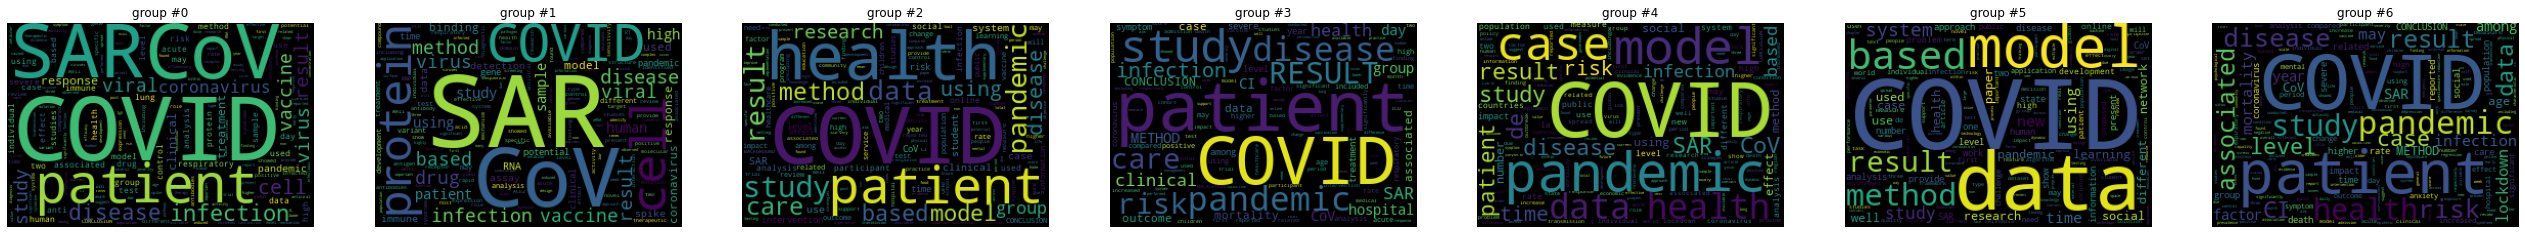

In [56]:
groups = df[['abstract','label']]

plt.figure(figsize=(45, 10)) 
for g in np.unique(groups.label):
  plot_cloud(groups.abstract[groups.label==g].tolist(),plottitle='group #'+str(g),sub_i=g)

In [57]:
gs = get_groups_pop_words(groups,20,'abstract')

for g in gs:
  print('group #' + str(g) +' : ',end='\t')
  print(gs[g],end='\n\n')

group #0 : 	['cell', 'cells', 'clinical', 'coronavirus', 'disease', 'infection', 'patients', 'respiratory', 'severe', 'study', 'treatment', 'vaccine', 'viral', 'virus']

group #1 : 	['binding', 'cell', 'cells', 'disease', 'high', 'human', 'infection', 'protein', 'study', 'used', 'using', 'vaccine', 'viral', 'virus']

group #2 : 	['care', 'clinical', 'data', 'disease', 'health', 'model', 'patients', 'social', 'students', 'study', 'use', 'using']

group #3 : 	['95', 'care', 'ci', 'clinical', 'disease', 'health', 'hospital', 'infection', 'mortality', 'patients', 'risk', 'study', 'treatment']

group #4 : 	['cases', 'data', 'different', 'disease', 'health', 'model', 'patients', 'risk', 'social', 'study', 'time', 'using']

group #5 : 	['approach', 'data', 'different', 'learning', 'model', 'new', 'paper', 'social', 'study', 'time', 'use', 'used', 'using']

group #6 : 	['95', 'associated', 'ci', 'data', 'disease', 'health', 'infection', 'lockdown', 'mortality', 'patients', 'risk', 'social', 's

Although the groups(clusters) are still the same, there is somewhat of a different feeling.  
Howerver, not for from our explanation with the titles...  

- Group #0 - Diseases & Treatment
- Group #1 - Very Medical
- Group #2 - Research & study
- Group #3 - ..
- Group #4 - ..
- Group #5 - Social aspect
- Group #6 - Epidemic


<br><br><br>

Group #5 vs #6 - Topic modeling

In [61]:
def print_topics(model, feature_names, n_top_words=20):
      for topic_idx, topic in enumerate(model.components_):
          print("Topic %d:" % (topic_idx),end='\t')
          print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

def topics(i_group,n_topics=3,n_top_words=10,n_features=1000,display=True,by='title'):
  documents = groups[groups.label==i_group][by].to_list()

  tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
  tf = tf_vectorizer.fit_transform(documents)
  tf_feature_names = tf_vectorizer.get_feature_names()

  lda = LatentDirichletAllocation(n_components=n_topics,max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

  print_topics(lda, tf_feature_names, n_top_words)

In [63]:
topics(i_group=0,by='abstract')

Topic 0:	covid 19 cov sars infection cells virus disease viral coronavirus
Topic 1:	cov sars antibodies antibody samples spike 19 vaccine covid abstract
Topic 2:	19 covid patients study results risk disease clinical infection vaccine


In [65]:
topics(i_group=1,by='abstract')

Topic 0:	19 covid cells sars cov cell immune vaccine infection disease
Topic 1:	sars cov binding protein virus spike viral 19 rna covid
Topic 2:	covid 19 based using results methods detection used data method


In [64]:
topics(i_group=2,by='abstract')

Topic 0:	health care study research 19 students based covid data pandemic
Topic 1:	covid 19 patients sars cov study 95 results ci disease
Topic 2:	covid 19 pandemic health social vaccine study vaccination model public


In [67]:
topics(i_group=5,by='abstract')

Topic 0:	social research study based data learning health new online covid
Topic 1:	data la software el based systems en paper energy results
Topic 2:	covid 19 model based sars cov disease data results using


In [68]:
topics(i_group=6,by='abstract')

Topic 0:	19 covid health lockdown anxiety study pandemic mental depression associated
Topic 1:	covid 19 pandemic health study social results data people related
Topic 2:	covid 19 patients disease mortality risk sars cov study 95


We still can see that:

- Group #1 - Very Medical
- Group #2 - Research & study
- Group #6 - Epidemic

<br><br>

NICE!!!

<br><br><br><br>

Thanks for reading....